In [1]:
%matplotlib inline

from Bio.Seq import Seq
from Bio import SeqIO
from Bio.Alphabet import IUPAC

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier

import shap

In [2]:
shap.__version__

'0.28.5'

### NHP Sequence alignment files (.aln format)

Put the files names (relative paths) in a list.

We will iterate over this list to read the sequences into dataframes.

In [3]:
file_1 = '../DATA/!CLEAN/2019-01-30_ZIBRA2_YFV-RIO-Diferentes_CTs'

file_2 = '../DATA/!CLEAN/NHP_65_outbreak'

file_3 = '../DATA/!CLEAN/2018-01_Salvador'

file_4 = '../DATA/!CLEAN/2018-03-04_LACEN_Bahia'

file_5 = '../DATA/!CLEAN/FUNED_AGOSTO-2018'

file_6 = '../DATA/!CLEAN/RIO_DE_JANEIRO'

file_7 = '../DATA/!CLEAN/YFV_LACEN_BAHIA'

In [4]:
file_list = [file_1,
            file_2,
            file_3,
            file_4,
            file_5,
            file_6,
            file_7]
seq_list = []
metadata_list = []

In [5]:
for file in file_list:
    seq_file = file + '.aln'
    metadata_file = file + '.xlsx'
    
    seq_list.append(seq_file)
    metadata_list.append(metadata_file)

### NHP Metadata
The following code reads the excel spreadsheet containing the metadata related to the sequences and includes them in the dataframe.

One spreadsheet per group of sequences from ZIBRA database, all into a _dictionary_.

I only keep the information I'm going to use now, i.e., 'Host', 'Date' and 'Ct'.

I use regex to link the spreadsheet to the sequences.


In [6]:
def read_metadata(excel_file):
    metadata_df = pd.read_excel(excel_file, index_col='index')
    metadata_df = metadata_df[['Host', 'Date', 'Ct', 'Virus']]
    return metadata_df

In [7]:
metadata_dict = {}
for file in metadata_list:
    print(file)
    metadata_df = read_metadata(file)
    metadata_dict[file] = metadata_df

../DATA/!CLEAN/2019-01-30_ZIBRA2_YFV-RIO-Diferentes_CTs.xlsx
../DATA/!CLEAN/NHP_65_outbreak.xlsx
../DATA/!CLEAN/2018-01_Salvador.xlsx
../DATA/!CLEAN/2018-03-04_LACEN_Bahia.xlsx
../DATA/!CLEAN/FUNED_AGOSTO-2018.xlsx
../DATA/!CLEAN/RIO_DE_JANEIRO.xlsx
../DATA/!CLEAN/YFV_LACEN_BAHIA.xlsx


In [8]:
sizes = [len(metadata_dict[file]) for file in metadata_list]
n_meta = sum(sizes)
print(sizes)
print(n_meta)

[60, 27, 21, 11, 15, 2, 22]
158


In [9]:
indexes = [metadata_dict[file].index for file in metadata_list]
sum([len(index) for index in indexes])

158

### Merge all dataframes into one 

In [10]:
metadata = list(metadata_dict.values())

In [11]:
metadata = pd.concat(metadata)

In [12]:
metadata.shape

(158, 4)

### Data Cleaning

In [13]:
# Remove rows containing NaN or empty values in the Ct column
metadata = metadata[metadata['Ct'].notnull()]
#metadata = metadata[metadata['Ct'] != 'ct']

# Make sure values in Ct column are float numeric
metadata['Ct'] = pd.to_numeric(metadata['Ct'])
metadata['Ct'] = metadata['Ct'].astype(np.float16)

# Make sure values in Date are datetime
metadata['Date'] = pd.to_datetime(metadata['Date'])

# Correct some values
metadata.replace('Allouata', 'Alouatta', inplace=True)
metadata.replace('cebidae', 'Cebidae', inplace=True)
metadata.replace('NHP (unk)', 'unk', inplace=True)
metadata.replace('Sem informação','unk', inplace=True)
metadata.replace('Leontopithecus rosalia','L. rosalia', inplace=True)
metadata['Virus'] = "YFV"

# Show all hosts present
print(metadata['Host'].unique())
#print(metadata.head())

['Alouatta' 'Callithrix' 'Callicebus' 'L. rosalia' 'Cebus' 'unk' 'Cebidae'
 'H' 'NHP']


In [14]:
#metadata

# Data exploration

The next session explores how Ct value changes by species and by epidemic period.
The initial hypothesis was that Ct values of Callithrix samples were increasing. However, the data analysis below shows it's not the case.

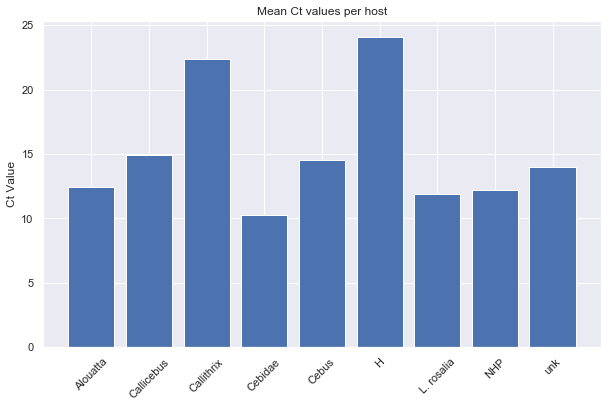

In [15]:
# First quick verification.
# Mean Ct values per host type:
mean_cts = metadata.groupby('Host')['Ct'].mean()
fig1, axes1 = plt.subplots(figsize=(10, 6))
axes1.bar(mean_cts.index, mean_cts)
axes1.set_title("Mean Ct values per host")
axes1.set_ylabel("Ct Value")
for tick in axes1.get_xticklabels():
    tick.set_rotation(45)

## Seasons

In [16]:
# Insert another column on the dataset to hold the epidemiologic season
# 2016/2017
# 2017/2018
metadata.insert(4, 'Season', 'season')

In [17]:
# Fill season values based on date condition:
# season 1: before August 2017
# season 2: after August 2017
mask = metadata['Date'] < pd.datetime(2017,8,1)
metadata.loc[mask, 'Season'] = '2016/2017'

mask = metadata['Date'] >= pd.datetime(2017,8,1)
metadata.loc[mask, 'Season'] = '2017/2018'

metadata.head()

,Host,Date,Ct,Virus,Season
index,,,,,
RJY01,Alouatta,2017-03-08,11.218750,YFV,2016/2017
RJY02,Alouatta,2017-03-19,8.000000,YFV,2016/2017
RJY03,Alouatta,2017-05-02,11.562500,YFV,2016/2017
RJY04,Alouatta,2017-12-22,11.453125,YFV,2017/2018
RJY05,Alouatta,2018-01-18,11.039062,YFV,2017/2018


## High and Low Ct's

In [18]:
# Insert another column on the dataset to hold the Ct group
# high = 1
# low = 0
metadata.insert(5, 'Ct_Group', 0)

In [19]:
Ct_threshold = 20

In [20]:
# Fill Ct groups based on:
# high: Ct > 20
# low: Ct <= 20
mask = metadata['Ct'] <= Ct_threshold
metadata.loc[mask, 'Ct_Group'] = 0

mask = metadata['Ct'] > Ct_threshold
metadata.loc[mask, 'Ct_Group'] = 1

metadata.head()

,Host,Date,Ct,Virus,Season,Ct_Group
index,,,,,,
RJY01,Alouatta,2017-03-08,11.218750,YFV,2016/2017,0
RJY02,Alouatta,2017-03-19,8.000000,YFV,2016/2017,0
RJY03,Alouatta,2017-05-02,11.562500,YFV,2016/2017,0
RJY04,Alouatta,2017-12-22,11.453125,YFV,2017/2018,0
RJY05,Alouatta,2018-01-18,11.039062,YFV,2017/2018,0


## First quick verification

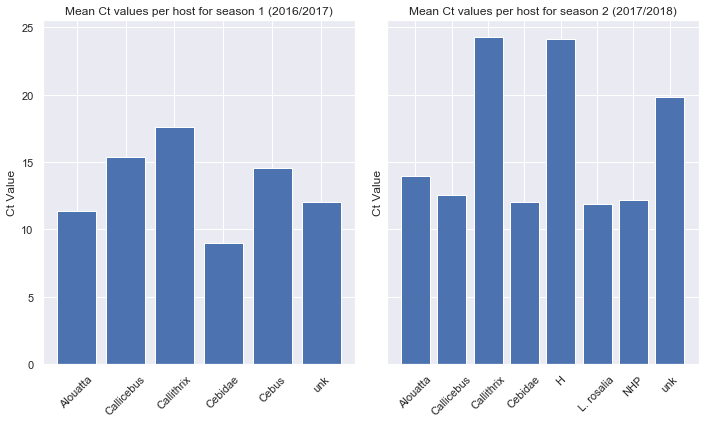

In [21]:
# First quick verification.
# Mean Ct values per host type:
fig2, axes2 = plt.subplots(figsize=(10, 6), nrows=1, ncols=2, sharey=True)
i=0
for group, group_df in metadata.groupby('Season'):
    mean_cts = group_df.groupby('Host')['Ct'].mean()
    axes2[i].bar(mean_cts.index, mean_cts)
    axes2[i].set_title("Mean Ct values per host for season {0} ({1})".format(i+1, group))
    axes2[i].set_ylabel("Ct Value")
    for tick in axes2[i].get_xticklabels():
        tick.set_rotation(45)
    i += 1
fig2.tight_layout()

In [22]:
for host, host_data in metadata.groupby('Host'):
    print(host)
    print(host_data.groupby('Season')['Ct'].mean(), '\n')
    #print(b)

Alouatta
Season
2016/2017    11.372031
2017/2018    13.994575
Name: Ct, dtype: float64 

Callicebus
Season
2016/2017    15.385938
2017/2018    12.585938
Name: Ct, dtype: float64 

Callithrix
Season
2016/2017    17.594866
2017/2018    24.300245
Name: Ct, dtype: float64 

Cebidae
Season
2016/2017     8.997210
2017/2018    12.004687
Name: Ct, dtype: float64 

Cebus
Season
2016/2017    14.546875
Name: Ct, dtype: float64 

H
Season
2017/2018    24.114583
Name: Ct, dtype: float64 

L. rosalia
Season
2017/2018    11.882812
Name: Ct, dtype: float64 

NHP
Season
2017/2018    12.175781
Name: Ct, dtype: float64 

unk
Season
2016/2017    12.066406
2017/2018    19.855469
Name: Ct, dtype: float64 



In [23]:
import seaborn as sns
sns.set(style="whitegrid")

In [24]:
meta_cal_alo = metadata[(metadata['Host'] == 'Callithrix') | (metadata['Host'] == 'Alouatta')]

In [25]:
# Separate two datasets, one for each host

callithrix_df = metadata[metadata['Host'] == 'Callithrix']
alouatta_df = metadata[metadata['Host'] == 'Alouatta']

### Do we have a balanced dataset?

In [26]:
print("Total {0} samples: {1}".format(callithrix_df["Host"][0], len(callithrix_df)))
print("{0} samples in Season {1}: {2}".format(callithrix_df["Host"][0], "2016/2017", len(callithrix_df[callithrix_df["Season"]=="2016/2017"])))
print("{0} samples in Season {1}: {2}".format(callithrix_df["Host"][0], "2017/2018", len(callithrix_df[callithrix_df["Season"]=="2017/2018"])))

Total Callithrix samples: 72
Callithrix samples in Season 2016/2017: 21
Callithrix samples in Season 2017/2018: 51


In [27]:
print("Total {0} samples: {1}".format(callithrix_df["Host"][0], len(callithrix_df)))
print("{0} samples with high Ct: {1}".format(callithrix_df["Host"][0], len(callithrix_df[callithrix_df["Ct_Group"]==1])))
print("{0} samples with low Ct: {1}".format(callithrix_df["Host"][0], len(callithrix_df[callithrix_df["Ct_Group"]==0])))

Total Callithrix samples: 72
Callithrix samples with high Ct: 40
Callithrix samples with low Ct: 32


In [28]:
print("Total {0} samples: {1}".format(alouatta_df["Host"][0], len(alouatta_df)))
print("{0} samples in Season {1}: {2}".format(alouatta_df["Host"][0], "2016/2017", len(alouatta_df[alouatta_df["Season"]=="2016/2017"])))
print("{0} samples in Season {1}: {2}".format(alouatta_df["Host"][0], "2017/2018", len(alouatta_df[alouatta_df["Season"]=="2017/2018"])))

Total Alouatta samples: 43
Alouatta samples in Season 2016/2017: 25
Alouatta samples in Season 2017/2018: 18


In [29]:
print("Total {0} samples: {1}".format(alouatta_df["Host"][0], len(alouatta_df)))
print("{0} samples with high Ct: {1}".format(alouatta_df["Host"][0], len(alouatta_df[alouatta_df["Ct_Group"]==1])))
print("{0} samples with low Ct: {1}".format(alouatta_df["Host"][0], len(alouatta_df[alouatta_df["Ct_Group"]==0])))

Total Alouatta samples: 43
Alouatta samples with high Ct: 3
Alouatta samples with low Ct: 40


## Understanding how Ct values changed by season
The function below plots boxplots, violin plots and scatter plots comparing the Ct value for both seasons. 

In [30]:
def plot_figures(host1, host2, df1, df2):
    fig1, axes1 = plt.subplots(figsize=(12, 6), nrows=1, ncols=2, sharey=True)

    x1 = df1['Date'].values
    y1 = df1['Ct'].values
    
    x2 = df2['Date'].values
    y2 = df2['Ct'].values

    axes1[0].scatter(x1, y1)
    axes1[0].set_title(host1 + ' Ct values')
    
    axes1[0].set_xlabel('Date')
    axes1[0].set_ylabel('Ct')
    
    axes1[1].scatter(x2, y2)
    axes1[1].set_title(host2 + ' Ct values')
    
    axes1[1].set_xlabel('Date')
    axes1[1].set_ylabel('Ct')
    
    fig1.autofmt_xdate()
    
    fig1.savefig('Scatter_seasons.png', format='png', dpi=300, transparent=False)
    

    fig2, axes2 = plt.subplots(figsize=(12, 6), nrows=1, ncols=2, sharey=True)
    data1_17 = df1[df1['Date'] <= pd.datetime(2017,8,1)]
    data1_18 = df1[df1['Date'] > pd.datetime(2017,8,1)]
    data2_17 = df2[df2['Date'] <= pd.datetime(2017,8,1)]
    data2_18 = df2[df2['Date'] > pd.datetime(2017,8,1)]
    
    axes2[0].boxplot([data1_17['Ct'], data1_18['Ct']], labels=['2016/2017', '2017/2018'])
    axes2[0].set_title(host1 + ' Ct values boxplot per season')
    axes2[0].set_xlabel('Season')
    axes2[0].set_ylabel('Ct')
    
    axes2[1].boxplot([data2_17['Ct'], data2_18['Ct']], labels=['2016/2017', '2017/2018'])
    axes2[1].set_title(host2 + ' Ct values boxplot per season')
    axes2[1].set_xlabel('Season')
    axes2[1].set_ylabel('Ct')
    
    fig2.savefig('BoxPlot_seasons.png', format='png', dpi=300, transparent=False)
    
    
    fig3, axes3 = plt.subplots(figsize=(12, 6), nrows=1, ncols=2, sharey=True)
    sns.violinplot(x="Season", y="Ct", data=df1, ax=axes3[0])
    sns.violinplot(x="Season", y="Ct", data=df2, ax=axes3[1])
    axes3[0].set_title(host1 + ' Ct values violin plot per season')
    axes3[1].set_title(host2 + ' Ct values violin plot per season');
    
    fig3.savefig('ViolinPlot.png', format='png', dpi=300, transparent=False)

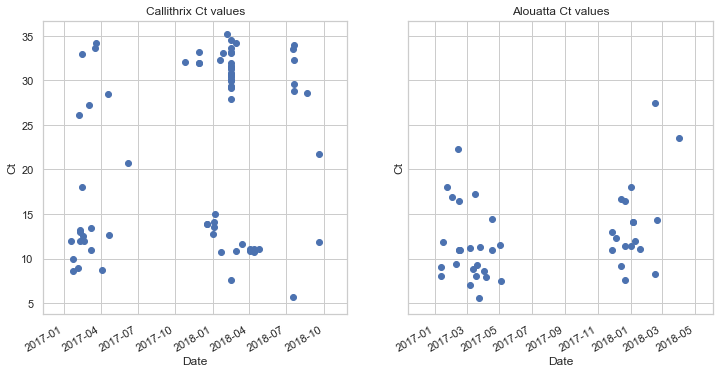

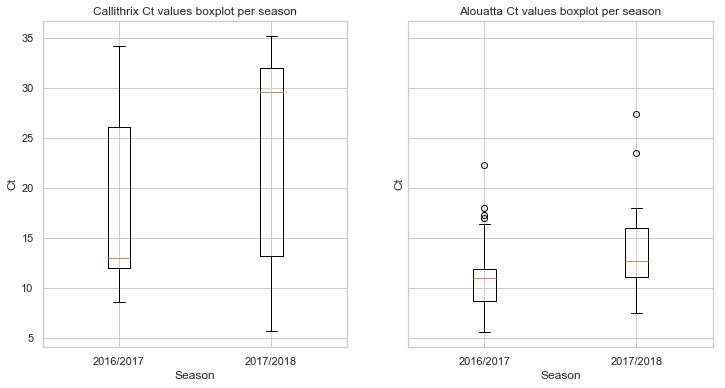

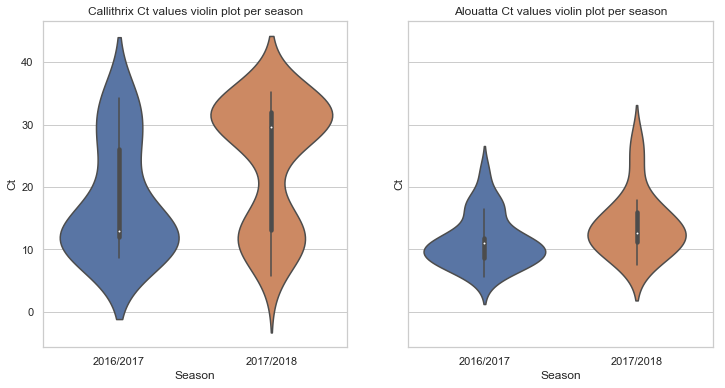

In [31]:
plot_figures('Callithrix', 'Alouatta', callithrix_df, alouatta_df)

## Understanding how Ct values changed by High/Low groups


In [32]:
def plot_figures_2(host1, host2, df1, df2):
    fig1, axes1 = plt.subplots(figsize=(12, 6), nrows=1, ncols=2, sharey=True)

    x1 = df1['Date'].values
    y1 = df1['Ct'].values
    
    x2 = df2['Date'].values
    y2 = df2['Ct'].values

    axes1[0].scatter(x1, y1)
    axes1[0].set_title(host1 + ' Ct values')
    
    axes1[0].set_xlabel('Date')
    axes1[0].set_ylabel('Ct')
    
    axes1[1].scatter(x2, y2)
    axes1[1].set_title(host2 + ' Ct values')
    
    axes1[1].set_xlabel('Date')
    axes1[1].set_ylabel('Ct')
    
    fig1.autofmt_xdate()
    
    fig1.savefig('Scatter_seasons.png', format='png', dpi=300, transparent=False)
    
    fig2, axes2 = plt.subplots(figsize=(12, 6), nrows=1, ncols=2, sharey=True)
    data1_low = df1[df1['Ct_Group'] == 0]
    data1_high = df1[df1['Ct_Group'] == 1]
    data2_low = df2[df2['Ct_Group'] == 0]
    data2_high = df2[df2['Ct_Group'] == 1]
    
    axes2[0].boxplot([data1_low['Ct'], data1_high['Ct']], labels=['low', 'high'])
    axes2[0].set_title(host1 + ' Ct values boxplot per High/Low group')
    axes2[0].set_xlabel('Group')
    axes2[0].set_ylabel('Ct');
    
    axes2[1].boxplot([data2_low['Ct'], data2_high['Ct']], labels=['low', 'high'])
    axes2[1].set_title(host2 + ' Ct values boxplot per High/Low group')
    axes2[1].set_xlabel('Group')
    axes2[1].set_ylabel('Ct');
    
    fig2.savefig('BoxPlot_highlow.png', format='png', dpi=300, transparent=False)
    
    fig3, axes3 = plt.subplots(figsize=(12, 6), nrows=1, ncols=2, sharey=True)
    sns.violinplot(x="Host", y="Ct", data=df1, ax=axes3[0])
    sns.violinplot(x="Host", y="Ct", data=df2, ax=axes3[1])
    
    axes3[0].set_title(host1 + ' Ct values violin plot');
    axes3[1].set_title(host2 + ' Ct values violin plot');
    
    fig3.savefig('ViolinPlot_highlow.png', format='png', dpi=300, transparent=False)

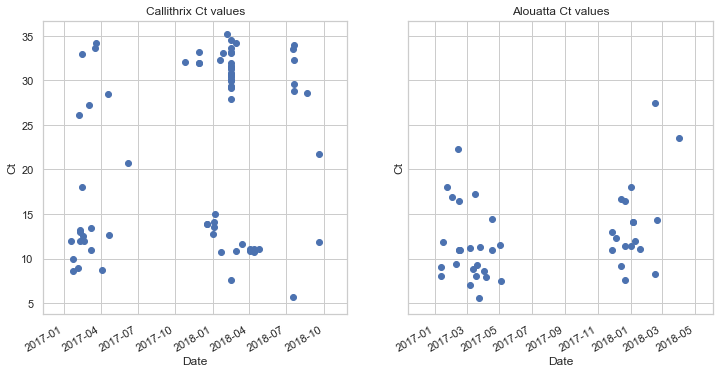

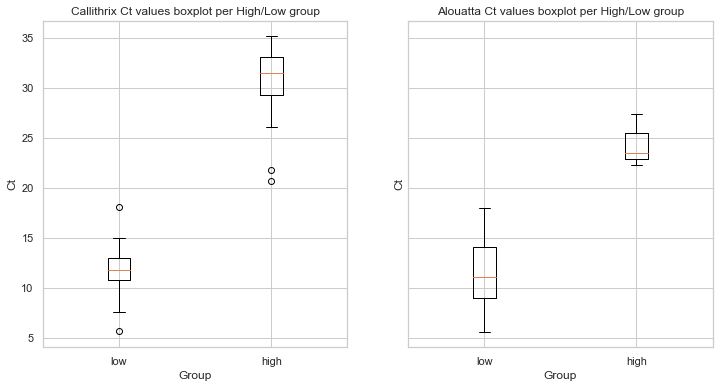

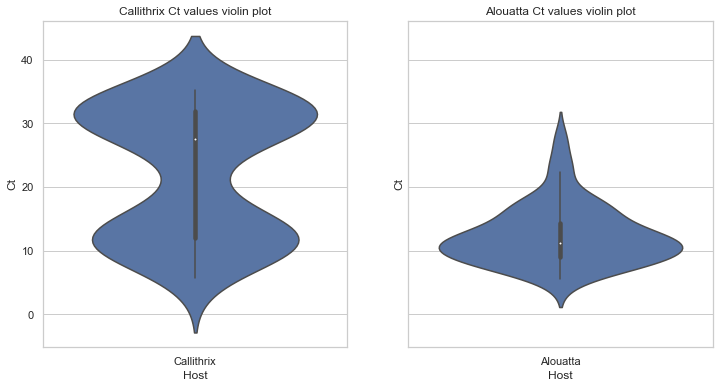

In [33]:
plot_figures_2('Callithrix', 'Alouatta', callithrix_df, alouatta_df)